In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
import joblib

from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

In [9]:
# Charger les données
file_path = "../data/raw/department_ain_data_59_days_export.csv"
df = pd.read_csv(file_path, index_col=0)
df.drop(columns=['department'], inplace=True)

# Conversion de la colonne dates en datetime et définition de l'index
df['dates'] = pd.to_datetime(df['dates'])
df.set_index('dates', inplace=True)
# Sélection de la variable cible
target = 'solarenergy_kwhpm2'

In [ ]:
df1 = df.copy()

In [4]:
# Separate train et test data (80% train, 20% test)
n = int(len(df) * 0.8)
df_train, df_test = df.iloc[:n], df.iloc[n:]

# skforecast model selection
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(n_estimators=100, random_state=42),
    lags=40  # use the last (lags value) days as features
)

# model training
forecaster.fit(y=df_train[target])


/home/dk.busimanager/code/donat-konan33/weatherteam_streamlit_dashboard/.venv/lib/python3.9/site-packages/skforecast/utils/utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/dk.busimanager/code/donat-konan33/weatherteam_streamlit_dashboard/.venv/lib/python3.9/site-packages/skforecast/utils/utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [5]:
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] 
Transformer for y: None 
Transformer for exog: None 
Window size: 40 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 46] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-04-02 11:58:42 
Last fit date:

/home/dk.busimanager/code/donat-konan33/weatherteam_streamlit_dashboard/.venv/lib/python3.9/site-packages/skforecast/utils/utils.py:1120: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


MAE: 1.7094
MSE: 3.2969
RMSE: 1.8157
r2_score: -1.2476


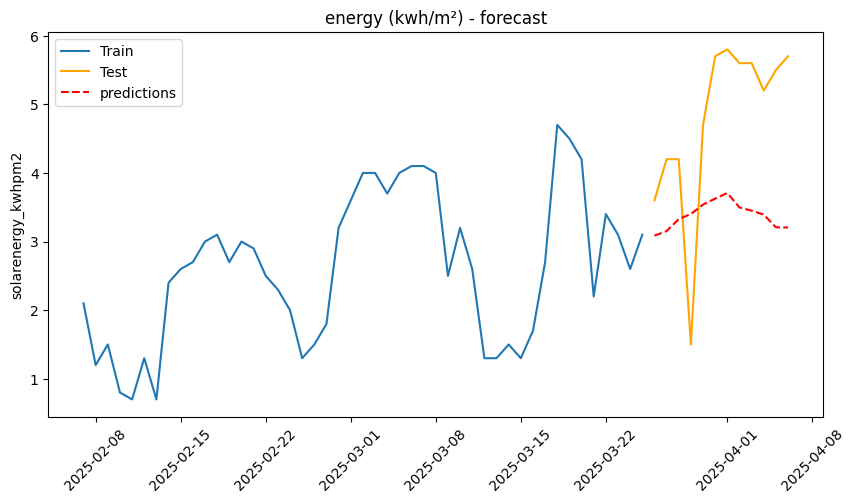

In [7]:
# predicting the next days on df_test
predictions = forecaster.predict(steps=len(df_test))

# Model evaluation
mae = mean_absolute_error(df_test[target], predictions)
mse = mean_squared_error(df_test[target], predictions)
rmse = root_mean_squared_error(df_test[target], predictions)
r2score = r2_score(df_test[target], predictions)
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'r2_score: {r2score:.4f}')


# result visualization
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train[target], label='Train')
plt.plot(df_test.index, df_test[target], label='Test', color='orange')
plt.plot(df_test.index, predictions, label='predictions', color='red', linestyle='dashed')
plt.legend()
plt.title("energy (kwh/m²) - forecast")
plt.xticks(rotation=45)
plt.ylabel('solarenergy_kwhpm2')
plt.show()


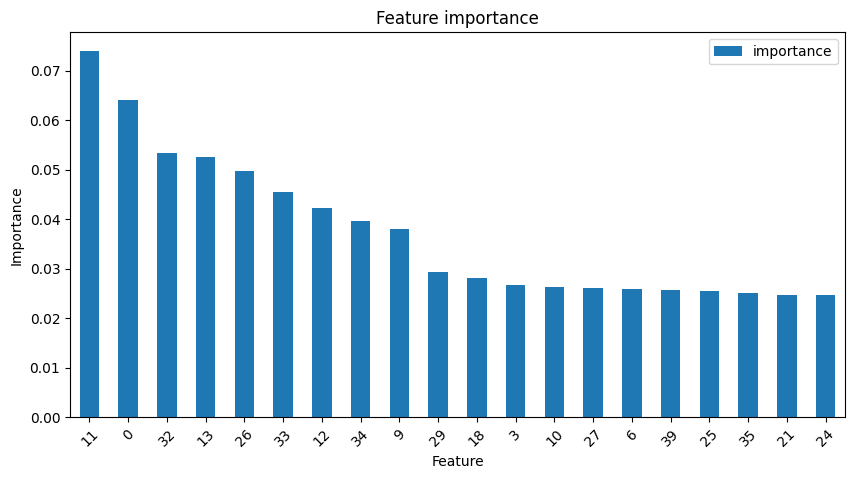

In [28]:
forecaster.get_feature_importances().sort_values(ascending=False, by='importance').head(20).plot(kind='bar', figsize=(10, 5))
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Sauvegarde du modèle
joblib.dump(forecaster, "skforecast_model.pkl")
print("Modèle sauvegardé sous 'skforecast_model.pkl'")

# **Other Approach**

In [69]:
# Separate train et test data (80% train, 20% test)
n = int(len(df1) * 0.8)
df1 = df1.asfreq('D')
df1_train, df1_test = df1.iloc[:n], df1.iloc[n:]

# --- Modeling ---
forecaster_1 = ForecasterAutoreg(
    regressor=RandomForestRegressor(n_estimators=100, random_state=42),
    lags=2  # optimized for little datasets
)

# separate target and exogenous features
exog_features = df1_train.columns.difference([target])
# model training
forecaster_1.fit(y=df1_train[target], exog=df1_train[exog_features])

MAE: 0.7577
MSE: 0.8953
RMSE: 0.9462
r2_score: 0.3897


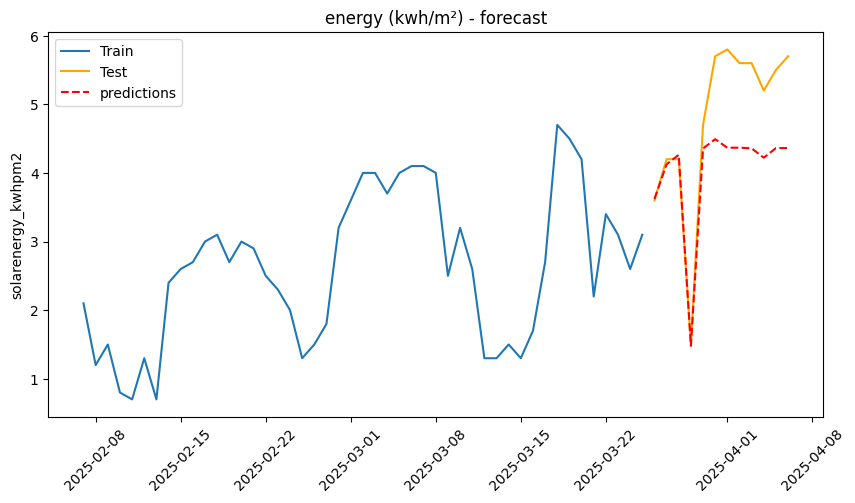

In [70]:
predictions_1 = forecaster_1.predict(steps=len(df1_test), exog=df1_test[exog_features])
# Model evaluation
mae_1 = mean_absolute_error(df1_test[target], predictions_1)
mse_1 = mean_squared_error(df1_test[target], predictions_1)
rmse_1 = root_mean_squared_error(df1_test[target], predictions_1)
r2score_1 = r2_score(df1_test[target], predictions_1)
print(f'MAE: {mae_1:.4f}')
print(f'MSE: {mse_1:.4f}')
print(f'RMSE: {rmse_1:.4f}')
print(f'r2_score: {r2score_1:.4f}')
# result visualization
plt.figure(figsize=(10, 5))
plt.plot(df1_train.index, df1_train[target], label='Train')
plt.plot(df1_test.index, df1_test[target], label='Test', color='orange')
plt.plot(df1_test.index, predictions_1, label='predictions', color='red', linestyle='dashed')
plt.legend()
plt.title("energy (kwh/m²) - forecast")
plt.xticks(rotation=45)
plt.ylabel('solarenergy_kwhpm2')
plt.show()


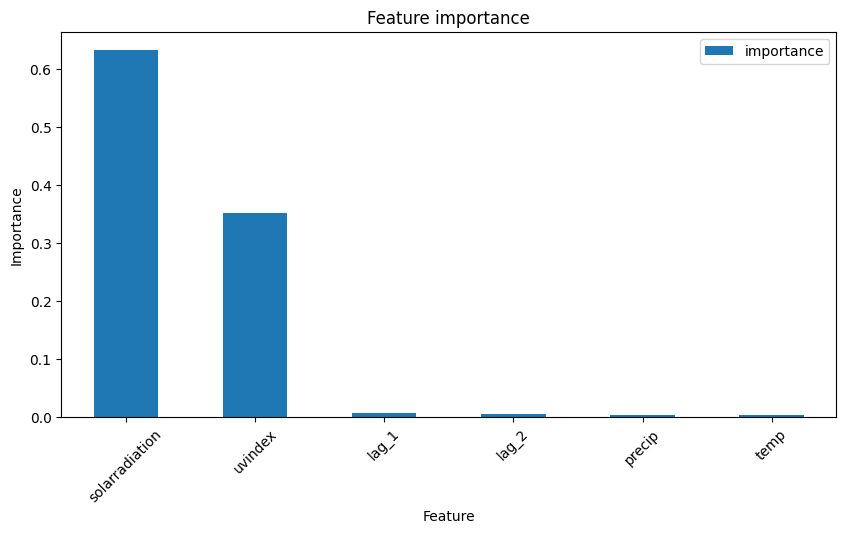

In [72]:
forecaster_1.get_feature_importances().sort_values(ascending=False, by='importance').head(20).plot(x="feature",kind='bar', figsize=(10, 5))
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.show()

# First Summary 
We found here that exogenous variables may help our model to predict with more accuracy.
But it important here to note that based on our first EDA studies ([see notebook](../notebooks/eda.ipynb)) there exist correlation between of some features each other and other extremely against the target `solar_energykwhpm2`, that a good thing. 

However our goal is not to predict values of variable target we could extract via an weather API.
We aim to predict the real energy (hourly, daily, monthly, half-yearly and yearly) available in order to help family using our app to anticipate their household consumption: EFFICIENCY.

This parameters, once panel is installed, are constant so that 
- Panel inclination angle
- Location
- Type of panel device

Are not considered exogenous

These one are exogenous:
- Temperature 
- Precipitation
- Cloudcover
- Solarradiation
- Age of panel

This one study needs more data (around data for one year at least) to get more accuracy when predicting.